In [110]:
from os import listdir
from os.path import isfile, join

def getFilenames(path):
    return [path+f for f in listdir(path) if isfile(join(path, f))]

# Get argus data
arguspath = "data/argus/csv/"
argusCSVs = getFilenames(arguspath)

# Get pcap data
pcappath = "data/csv/"
pcapCSVs = getFilenames(pcappath)

# Get server logs
logpath = "data/experiment0-0.01/shadow.data/hosts/mymarkovservice0/"
logs = getFilenames(logpath)

# Combine all locations
data = argusCSVs + pcapCSVs + logs

import pandas as pd
import numpy as np
df = pd.read_csv (pcapCSVs[0])
len(logs)

8

In [122]:
import json 

class PrivacyScope:

    def __init__(self, filenames, name):
        self.name = name
        self.filenames = filenames
        self.time_format = '%b %d, %Y %X.%f'
        self.time_cut_tail = -7
        self.time_col = 'frame.time'
        self.filter_func = lambda df, args: df
        self.df = None
        self.ip_search_enabled = False
        self.cache_search_enabled = False
        self.cache_timing = pd.Timedelta("300 seconds")
    
    def __str__(self):
        return "PrivacyScope(" + self.name + ")"
    
    def __repr__(self):
        return str(self)
    
    def set_offset(self, timeoffset):
        self.timeoffset = timeoffset
        self.as_df()
        self.df[self.time_col] +=timeoffset
    
    def process_log(self, fn, sep='\t', cols=["time", "format", "data"]):
        df = pd.read_csv(fn,sep=sep, names=cols)
        m = pd.json_normalize(df["data"].apply(json.loads))
        df.drop(["data"], axis=1, inplace=True)
        df = pd.concat([df, m], axis = 1, sort=False)
        return df

    def as_df(self, filenames=None):
        if self.df is not None:
            return self.df
        if filenames == None:
            filenames = self.filenames
        df = pd.DataFrame()
        for f in filenames:
            if f.endswith(".csv"):
                ddf = pd.read_csv (f)
            elif f.endswith("stdout"):
                ddf = self.process_log(f)
            df = pd.concat([df, ddf])
        self.df = df
        self.format_time_col()
        return self.df
        
    def get_ts(self):
        return None
    
    def format_time_col(self):
        if self.time_format == 'epoch':
            self.df[self.time_col] = self.df[self.time_col].apply(lambda x: datetime.fromtimestamp(float(x)))
        else:
            self.df[self.time_col] = self.df[self.time_col].apply(lambda x: datetime.strptime(x[:self.time_cut_tail], self.time_format))
        # print(self.df)
        # self.df.set_index(self.time_col, inplace=True)
        return self.df

    def pcap_only(self):
        r = re.compile(".*data/csv.*")
        return list(filter(r.match, self.filenames))
    
    def pcap_df(self):
        return self.as_df(filenames=self.pcap_only())
    
    def set_filter(self, filter_func):
        self.filter_func = filter_func
        
    def run_filter(self, args):
        return self.filter_func(self.as_df(), args)
    
    def filterByIP(self, ip, run_filter=True, args=None):
        df = self.as_df()
        if run_filter:
            df = self.run_filter(args)
        return df[((df['ip.dst'] == ip) | \
                                   (df['ip.src'] == ip))]

    def filterByCache(self, ip, cache_data, run_filter=True, args=None):
        df = self.as_df()
        if run_filter:
            df = self.run_filter(args)

        df_times = df[self.time_col].tolist()
        input_times = cache_data[self.time_col].tolist()
        keepers = [False] * len(df_times)
        idx = 0
        stop = len(input_times)
        for i in range(0, len(df_times)):
            if idx >= stop:
                break
            diff = input_times[idx] - df_times[i]
            if diff <= pd.Timedelta(0):
                idx += 1
            elif diff < self.cache_timing:
                keepers[i] = True
        
        return df[keepers]
    
    def search(self, ip=None, cache_data=None):
        matches = []
        if self.ip_search_enabled and ip is not None:
            matches += [self.filterByIP(ip)]
        if self.cache_search_enabled and cache_data is not None:
            matches += [self.filterByCache(ip, cache_data)]
        return matches
    
    def remove_features(self, bad_features):
        df = self.as_df()
        df.drop(bad_features, inplace=True, axis=1)
        self.df = df
        
        

In [123]:
# Basic Scopes
import re

# Get all clients and ISP dns scope
r = re.compile(".*isp.csv|.*group[0-9]*user[0-9]*-(?!127\.0\.0\.1)[0-9]*.[0-9]*.[0-9]*.[0-9]*..csv")
ISP_scope = PrivacyScope(list(filter(r.match, data)), "ISP")


# Access to public resolver scope
r = re.compile(".*isp.*.csv")
Access_resolver = PrivacyScope(list(filter(r.match, data)), "Access_resolver")

r = re.compile("(.*tld).*.csv")
tld = PrivacyScope(list(filter(r.match, data)), "TLD")

r = re.compile("(.*root).*.csv")
root = PrivacyScope(list(filter(r.match, data)), "root")

r = re.compile("(.*sld).*.csv")
sld = PrivacyScope(list(filter(r.match, data)), "SLD")

# Access Tor Scope
r = re.compile(".*group[0-9]*user[0-9]*-(?!127\.0\.0\.1)[0-9]*.[0-9]*.[0-9]*.[0-9]*..csv")
Access_tor = PrivacyScope(list(filter(r.match, data)), "Access_tor")

# Server Public Scope
r = re.compile(".*myMarkovServer0*-(?!127\.0\.0\.1)[0-9]*\.[0-9]*\.[0-9]*\.[0-9]*.csv")
Server_scope = PrivacyScope(list(filter(r.match, data)), "Server_of_interest")

# tor Exit scope
r = re.compile(".*exit.*")
Tor_exit_Scope = PrivacyScope(list(filter(r.match, data)), "Tor_exit")

# tor Guard scope
r = re.compile(".*guard.*")
Tor_guard_Scope = PrivacyScope(list(filter(r.match, data)), "Tor_guard")

# tor Relay scope
r = re.compile(".*relay.*")
Tor_relay_Scope = PrivacyScope(list(filter(r.match, data)), "Tor_relay")

# tor Middle scope
r = re.compile(".*middle.*")
Tor_middle_Scope = PrivacyScope(list(filter(r.match, data)), "Tor_middle")

# tor 4uthority scope
r = re.compile(".*4uthority.*")
Tor_4uthority_Scope = PrivacyScope(list(filter(r.match, data)), "Tor_4uthority")

# resolver scope
r = re.compile(".*resolver.*")
resolver = PrivacyScope(list(filter(r.match, data)), "resolver")

In [124]:
from datetime import datetime

def df_to_ts(df, time_col='frame.time'):
    df['count'] = 1
    tmp = df.set_index(time_col).infer_objects()
    tmp = tmp.resample('1S').sum(numeric_only=True).infer_objects()
    return tmp.reset_index()

# get start time for GNS3
GNS3_data = pd.concat([Access_resolver.pcap_df(), sld.pcap_df(), tld.pcap_df(), root.pcap_df()])
GNS3_starttime = GNS3_data.head(1)['frame.time'].tolist()[0]
Shadow_starttime = datetime.strptime('Dec 31, 1999 19:26:00', '%b %d, %Y %X')
Shadow_offset = GNS3_starttime - Shadow_starttime
Shadow_offset

Timedelta('8532 days 16:40:25.326727')

In [125]:
# service log scope
r = re.compile(".*mymarkovservice.*py.*stdout")
chatlog = PrivacyScope(list(filter(r.match, data)), "chatlogs")
chatlog.time_col = "time"
chatlog.time_cut_tail = 0
chatlog.time_format = 'epoch'
chatlog.set_offset(Shadow_offset)

In [126]:
chatlog.as_df()

,time,format,username,text
0,2023-05-12 12:10:25.476727,application/json,/tordata/config/group_0_user_2,It's this line that tells me everything I need...
1,2023-05-12 12:10:26.577727,application/json,/tordata/config/group_0_user_2,"While I disagree with the weapon complaint, I ..."
2,2023-05-12 12:10:27.476728,application/json,/tordata/config/group_0_user_2,Yep. Weapons breaking isn't a big deal at all....
3,2023-05-12 12:10:27.676728,application/json,/tordata/config/group_0_user_2,I felt the same way. I saw a bunch of 10/10 re...
4,2023-05-12 12:10:28.476727,application/json,/tordata/config/group_0_user_2,it shows an orange and blue marker opposed to ...
...,...,...,...,...
4284,2023-05-12 14:11:36.476728,application/json,/tordata/config/group_4_user_0,"Yes, that's the point. They give you the freed..."
4285,2023-05-12 14:11:37.476727,application/json,/tordata/config/group_4_user_0,"The freedom to choose comes in regards to ""I d..."
4286,2023-05-12 14:11:37.676727,application/json,/tordata/config/group_4_user_0,I also apologize for my lazy answer previously...
4287,2023-05-12 14:11:38.476728,application/json,/tordata/config/group_4_user_0,"Hm, I guess I'd rather have all the possibilit..."


In [127]:
window = pd.Timedelta("300 seconds") # cache size but maybe smaller 

# detect and remove solo quries
# these can easily be handled on their own as only 1 device is accessing the network at that moment
def detect_solo(df_list):
    new_df = df_list[df_list['ip.src'].ne(df_list['ip.src'].shift())]
    new_df['diff'] = new_df['frame.time'].diff()
    new_df = new_df[new_df['diff'] > window]
    solo_ips = new_df['ip.src'].unique()
    return solo_ips

def handle_solo(solo):
    print("IPs that must trigger a cache miss: " + str(solo))
    
def solo_pipeline(df_list):
    fil = df_list[['ip.src', 'frame.time']]
    solo = detect_solo(fil)
    handle_solo(solo)
    return solo

In [128]:
def combineScopes(dfs):
    if len(dfs) < 1:
        return dfs
    return pd.concat(dfs)

def scopesToTS(dfs):
    output = []
    for df in dfs:
        if len(df) < 2:
            continue
        output += scopeToTS(df)
    return output

def scopeToTS(df):
    return df_to_ts(df.copy()).set_index('frame.time')

def scope_label(df, scope_name):
    for col in df.columns:
        df[col + "_" + scope_name] = df[col]
    df["scope_name"]=scope_name
    return df

In [129]:
tor_df = Access_tor.pcap_df()
t2 = tor_df[tor_df['tcp.payload'].notna()]
t2[t2['tcp.len'] > 500]

,frame.number,frame.time,ip.src,ip.dst,ip.proto,ip.len,tcp.srcport,tcp.dstport,tcp.ack,tcp.seq,...,udp.port,frame.time_relative,frame.time_delta,tcp.time_relative,tcp.time_delta,tcp.payload,dns.qry.name,dns.opt.client.addr4,dns.opt.client.addr6,dns.opt.client.addr
2,3,1969-12-31 19:04:01.100000,102.0.0.70,100.0.0.1,6,557,34119,9001,1,1,...,NaN,0.100000,0.000000,0.100000,0.000000,1603010200010001fc0303155eb0b2594a3bc4624b6a7c...,NaN,NaN,NaN,NaN
3,4,1969-12-31 19:04:01.200000,100.0.0.1,102.0.0.70,6,1210,9001,34119,2,1,...,NaN,0.200000,0.100000,0.200000,0.100000,160303009b020000970303fa0f3c31cc00d7ec80f426cc...,NaN,NaN,NaN,NaN
8,9,1969-12-31 19:04:01.300000,100.0.0.1,102.0.0.70,6,1500,9001,34119,4,4,...,NaN,0.300000,0.000000,0.300000,0.000000,17030308051cdb50da63a72a737e305db396374b719a6e...,NaN,NaN,NaN,NaN
10,11,1969-12-31 19:04:01.401000,100.0.0.1,102.0.0.70,6,638,9001,34119,4,5,...,NaN,0.401000,0.100000,0.401000,0.100000,b6306f3f127eea5d2dd0e97c68d64990c85725227c6b60...,NaN,NaN,NaN,NaN
11,12,1969-12-31 19:04:01.401000,102.0.0.70,100.0.0.1,6,1090,34119,9001,6,4,...,NaN,0.401000,0.000000,0.401000,0.000000,17030304152752985c54288292293ea60c35892d040511...,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16243,16244,1969-12-31 21:57:30.425952,102.0.0.93,88.198.177.122,6,1090,51446,9001,7,5,...,NaN,10409.425952,0.000000,0.501000,0.000000,170303041500a3c6df2f6820e3992b22e0600c9cf940b9...,NaN,NaN,NaN,NaN
16244,16245,1969-12-31 21:57:30.525952,88.198.177.122,102.0.0.93,6,576,9001,51446,6,7,...,NaN,10409.525952,0.100000,0.601000,0.100000,17030302134a7376c35500d96ed85c3a725c53b619eb1c...,NaN,NaN,NaN,NaN
16246,16247,1969-12-31 21:57:30.535952,88.198.177.122,102.0.0.93,6,1500,9001,51446,6,8,...,NaN,10409.535952,0.009000,0.611000,0.009000,1703030a1b9869b49ee4f0a813f67b257e9cdf13b7c92d...,NaN,NaN,NaN,NaN
16247,16248,1969-12-31 21:57:30.535952,88.198.177.122,102.0.0.93,6,1172,9001,51446,6,9,...,NaN,10409.535952,0.000000,0.611000,0.000000,5e2023d1a9e7c09e457a33aea7e73d749b8f41d6a37616...,NaN,NaN,NaN,NaN


In [130]:
# Setup filters for different scopes
evil_domain = 'evil.dne'
DNS_PORT = 853

dns_filter = lambda df, ip: df[(df['dns.qry.name'] == evil_domain )
                                            | (df['dns.qry.name'].isna()) & (df['tcp.dstport'] == DNS_PORT)]
resolver.set_filter(dns_filter)
root.set_filter(dns_filter)
tld.set_filter(dns_filter)
sld.set_filter(dns_filter)

resolver.ip_search_enabled = True
resolver.cache_search_enabled = False

root.ip_search_enabled = True
root.cache_search_enabled = True

sld.ip_search_enabled = True
sld.cache_search_enabled = True

tld.ip_search_enabled = True
tld.cache_search_enabled = True

TCP_PROTO = 6

tor_df[tor_df['tcp.payload'].notna()]
t2[t2['tcp.len'] > 500]

tor_filter = lambda df, ip: df[(df['tcp.len'] > 500) & (df['ip.proto'] == TCP_PROTO)]
Access_tor.set_filter(tor_filter)

Access_tor.ip_search_enabled = True
Access_tor.cache_search_enabled = True

In [131]:
# Cluster DNS
## Create ts for each IP
resolv_df = resolver.pcap_df()
resolv_df_filtered = resolv_df[resolv_df['tcp.dstport'] == DNS_PORT]
infra_ip = ['172.20.0.11', '172.20.0.12', '192.168.150.10', '172.20.0.10']
ips_seen = resolv_df_filtered['ip.src'].unique()
IPs = list(set(ips_seen) - set(infra_ip))
flows_ip = {}
flows_ts_ip_scoped = {}
flows_ts_ip_total = {}
# first_pass = resolv_df_filtered[((~resolv_df_filtered['ip.src'].isin(infra_ip)))  \
#                                          & (resolv_df_filtered['dns.qry.name'] == evil_domain)]
solo = solo_pipeline(first_pass)

# Add all scope data to IPs found in resolver address space
# This should be a valid topo sorted list of the scopes (it will be proccessed in order)
scopes = [resolver, root, tld, sld]#, Access_tor]
bad_features = ['tcp.dstport', 'tcp.srcport', 'udp.port', 'tcp.seq']
for scope in scopes:
    scope.remove_features(bad_features)
cache_window = window # see above 
print("scopes: " + str(scopes))
print("cache window: " + str(cache_window))

/tmp/ipykernel_2474163/717278234.py:43: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  ddf = pd.read_csv (f)


IPs that must trigger a cache miss: []
scopes: [PrivacyScope(resolver), PrivacyScope(root), PrivacyScope(TLD), PrivacyScope(SLD)]
cache window: 0 days 00:05:00


In [132]:
for ip in IPs:
    # Don't add known infra IPs or users that can are solo communicaters
    if ip in infra_ip or ip in solo:
        continue
    flows_ip[ip] = pd.DataFrame()
    flows_ts_ip_scoped[ip] = pd.DataFrame()
    flows_ts_ip_total[ip] = pd.DataFrame()
    for scope in scopes:
        # Find matches
        matches = scope.search(ip, flows_ip[ip])
        print(matches)
        break
        # Update df for ip
        combined_scope = combineScopes(matches)
        combined_scope = scope_label(combined_scope, scope.name)
        combined_scope["scope_name"]=scope.name
        flows_ip[ip] =combineScopes([flows_ip[ip],combined_scope])
        
        # update ts for ip
        new_ts_matches = scopeToTS(combined_scope)
        if len(new_ts_matches) == 0:
            continue
        new_ts_matches["scope_name"]=scope.name
        flows_ts_ip_scoped[ip] = combineScopes([flows_ts_ip_scoped[ip], new_ts_matches])
    if len(flows_ip[ip]) > 0:
        flows_ts_ip_total[ip] = scopeToTS(flows_ip[ip])
        
        # order df by time
        flows_ip[ip] = flows_ip[ip].set_index('frame.time')
        
        # sort combined df by timestamp
        flows_ip[ip].sort_index(inplace=True)
        flows_ts_ip_scoped[ip].sort_index(inplace=True)
        flows_ts_ip_total[ip].sort_index(inplace=True)
        
        # Preserve time col to be used for automated feautre engineering
        flows_ip[ip]['frame.time'] = flows_ip[ip].index
        flows_ts_ip_total[ip]['frame.time'] = flows_ts_ip_total[ip].index
        
        # label scope col as category
        flows_ip[ip]["scope_name"] = flows_ip[ip]["scope_name"].astype('category')
        flows_ts_ip_scoped[ip]["scope_name"] = flows_ts_ip_scoped[ip]["scope_name"].astype('category')
        
        # remove nans with 0
        flows_ip[ip].fillna(0, inplace=True)
        flows_ts_ip_scoped[ip].fillna(0, inplace=True)
        flows_ts_ip_total[ip].fillna(0, inplace=True)

KeyError: 'tcp.dstport'

In [93]:
solo

array([], dtype=object)

In [94]:
ips_seen

array(['102.0.0.12', '102.0.0.14', '102.0.0.10', '102.0.0.15',
       '102.0.0.17', '102.0.0.13', '102.0.0.18', '102.0.0.11',
       '102.0.0.16', '102.0.0.19', '102.0.0.20', '102.0.0.22',
       '102.0.0.21', '102.0.0.26', '102.0.0.25', '102.0.0.29',
       '102.0.0.24', '102.0.0.23', '102.0.0.27', '102.0.0.30',
       '102.0.0.32', '102.0.0.28', '102.0.0.33', '102.0.0.31',
       '102.0.0.36', '102.0.0.37', '102.0.0.35', '102.0.0.34',
       '102.0.0.38', '102.0.0.39', '102.0.0.40', '102.0.0.43',
       '102.0.0.41', '102.0.0.42', '102.0.0.48', '102.0.0.45',
       '102.0.0.44', '102.0.0.47', '102.0.0.49', '102.0.0.50',
       '102.0.0.54', '102.0.0.46', '102.0.0.52', '102.0.0.53',
       '102.0.0.56', '102.0.0.57', '102.0.0.51', '102.0.0.59',
       '102.0.0.58', '102.0.0.55', '102.0.0.60', '102.0.0.61',
       '102.0.0.64', '102.0.0.62', '102.0.0.63', '102.0.0.67',
       '102.0.0.68', '102.0.0.66', '102.0.0.74', '102.0.0.72',
       '102.0.0.71', '102.0.0.65', '102.0.0.73', '102.0

In [95]:
flows_ip[ip]

,frame.number,ip.src,ip.dst,ip.proto,ip.len,tcp.srcport,tcp.dstport,tcp.ack,tcp.seq,tcp.len,...,frame.time_relative_SLD,frame.time_delta_SLD,tcp.time_relative_SLD,tcp.time_delta_SLD,tcp.payload_SLD,dns.qry.name_SLD,dns.opt.client.addr4_SLD,dns.opt.client.addr6_SLD,dns.opt.client.addr_SLD,frame.time
frame.time,,,,,,,,,,,,,,,,,,,,,
2023-05-12 12:06:54.919261,124,192.168.150.10,172.20.0.11,17.0,65.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0,0.0,0.0,0.0,2023-05-12 12:06:54.919261
2023-05-12 12:06:54.919898,127,172.20.0.11,192.168.150.10,17.0,222.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0,0.0,0.0,0.0,2023-05-12 12:06:54.919898
2023-05-12 12:06:55.041392,108,192.168.150.10,172.20.0.12,17.0,65.0,0.0,0.0,0.0,0.0,0.0,...,59.621640,0.202990,0.0,0.0,0.0,evil.dne,0.0,0.0,0.0,2023-05-12 12:06:55.041392
2023-05-12 12:06:55.041941,109,172.20.0.12,192.168.150.10,17.0,314.0,0.0,0.0,0.0,0.0,0.0,...,59.622189,0.000549,0.0,0.0,0.0,evil.dne,0.0,0.0,0.0,2023-05-12 12:06:55.041941
2023-05-12 12:10:40.158203,31976,102.0.0.74,192.168.150.10,6.0,60.0,37230.0,853.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0,0.0,0.0,0.0,2023-05-12 12:10:40.158203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-12 16:04:07.428770,1353824,102.0.0.74,192.168.150.10,6.0,52.0,43442.0,853.0,2044.0,381.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0,0.0,0.0,0.0,2023-05-12 16:04:07.428770
2023-05-12 16:04:07.449114,1353826,102.0.0.74,192.168.150.10,6.0,52.0,43442.0,853.0,2366.0,381.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0,0.0,0.0,0.0,2023-05-12 16:04:07.449114
2023-05-12 16:04:07.449182,1353827,102.0.0.74,192.168.150.10,6.0,52.0,43442.0,853.0,2366.0,381.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0,0.0,0.0,0.0,2023-05-12 16:04:07.449182


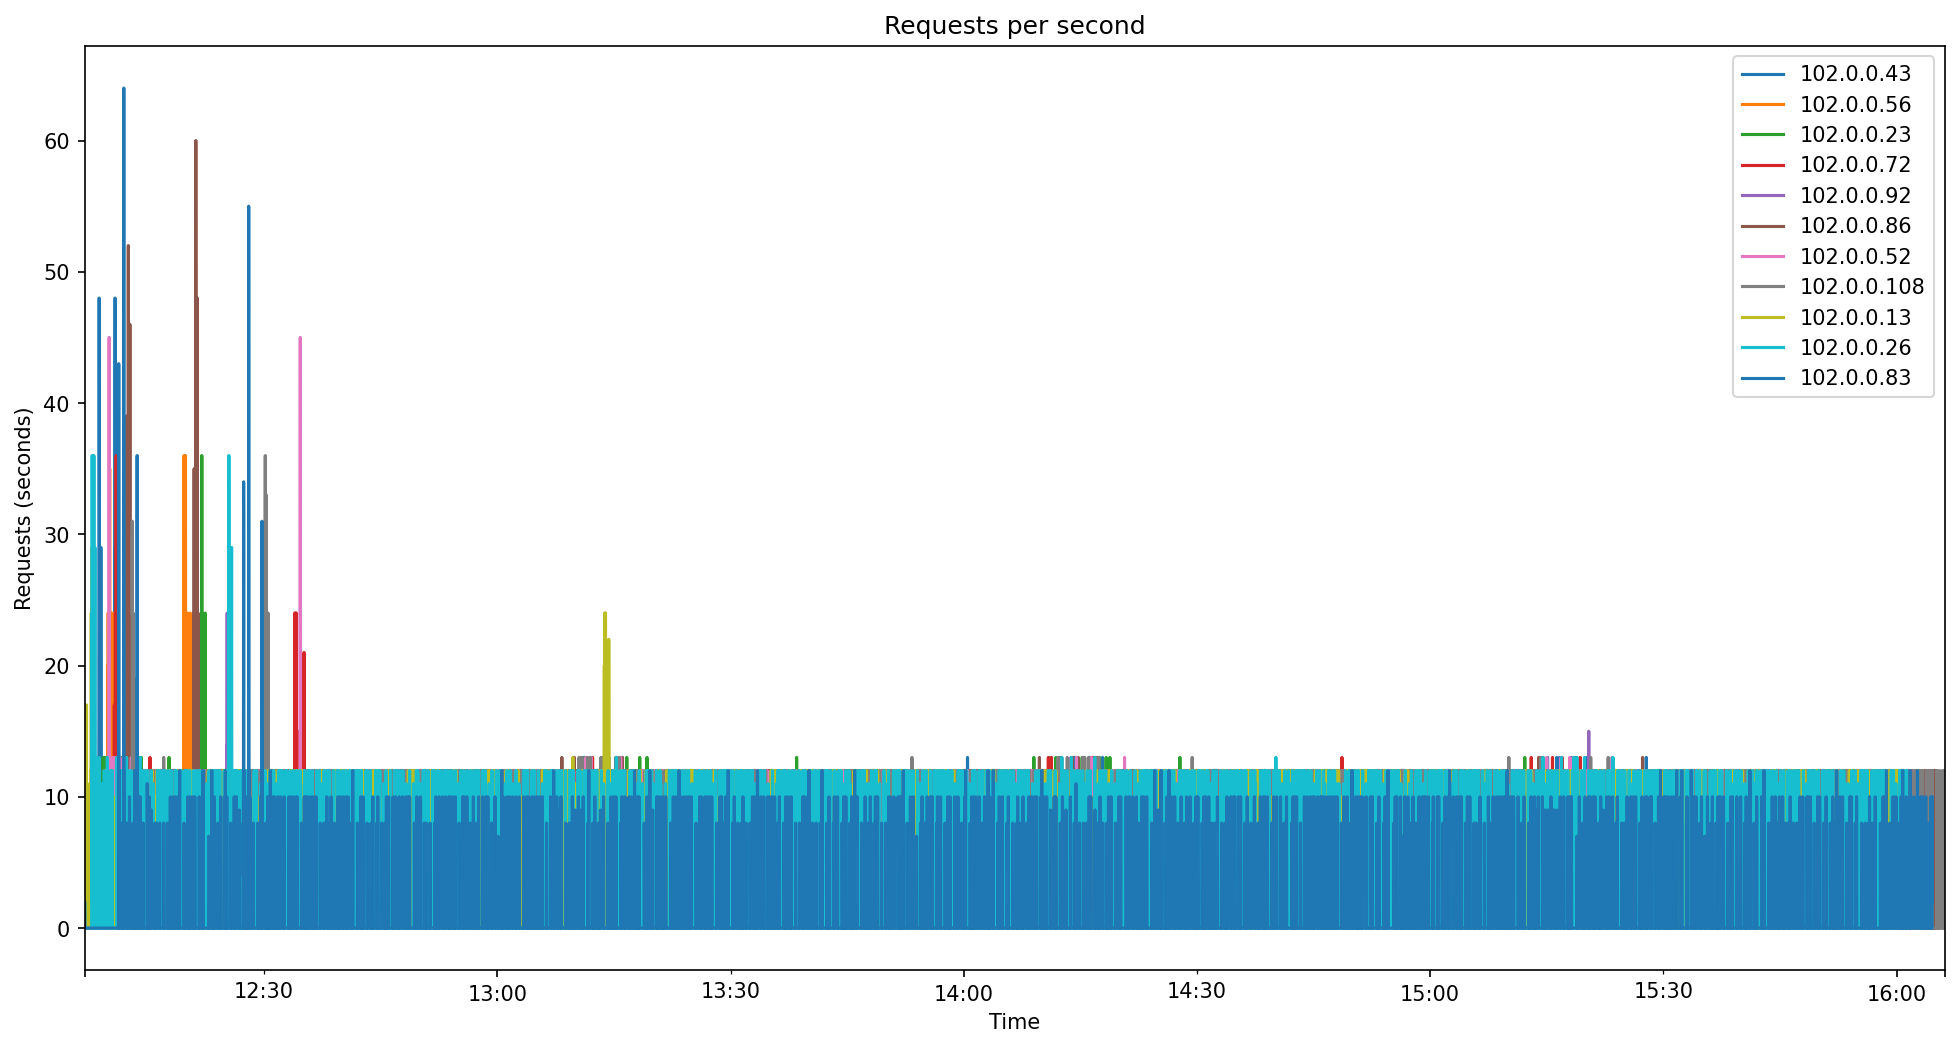

In [96]:
## Viz
# importing Libraries
  
# import pandas as pd
import pandas as pd
  
# importing matplotlib module
import matplotlib.pyplot as plt
plt.style.use('default')
  
# code
# Visualizing The Open Price of all the stocks
  
# to set the plot size
plt.figure(figsize=(16, 8), dpi=150)
  
# using plot method to plot open prices.
# in plot method we set the label and color of the curve.

total = 0
for f in flows_ts_ip_total:
    if total > 10:
        break
    total += 1
    flows_ts_ip_total[f]['count'].plot(label=f)
  
plt.title('Requests per second')
  
# adding Label to the x-axis
plt.xlabel('Time')
plt.ylabel('Requests (seconds)')
  
# adding legend to the curve
plt.legend()

In [97]:
import numpy as np
import math
from sklearn import metrics
from statistics import mean
from sklearn.metrics import confusion_matrix
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, fowlkes_mallows_score, homogeneity_completeness_v_measure

def ip_to_group(ip):
    if ip.split(".")[0] != '101':
        return -1
    return math.floor((int(ip.split(".")[-1])-2) / 5)

def get_real_label(dic):
    data = dic.keys()
    result = np.array([ip_to_group(xi) for xi in data])
    return result

# compute cluster purity
def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix) 

def weighted_purity(true_labels, found_labels):
    s = 0
    total = 0
    for c in true_labels.unique():
        selection = df[df['cluster'] == c]
        p = purity_score(selection['real_label'], selection['cluster'])
        total += len(selection)
        s += p * len(selection)
    return s/total

answers = get_real_label(flows_ts_ip_total)

In [98]:
def gpt_cluster_metrics(true_labels, found_labels):

    # Calculate the Adjusted Rand Index
    ari = adjusted_rand_score(true_labels, found_labels)
    ari_range = (-1, 1)
    ari_ideal = 1

    # Calculate the Normalized Mutual Information
    nmi = normalized_mutual_info_score(true_labels, found_labels)
    nmi_range = (0, 1)
    nmi_ideal = 1

    # Calculate the Fowlkes-Mallows Index
    fmi = fowlkes_mallows_score(true_labels, found_labels)
    fmi_range = (0, 1)
    fmi_ideal = 1

    # Calculate homogeneity, completeness, and V-measure
    homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(true_labels, found_labels)
    hcv_range = (0, 1)
    hcv_ideal = 1

    # Print the results
    print(f"Adjusted Rand Index: {ari:.4f} [range: {ari_range}, ideal: {ari_ideal}]")
    print(f"Normalized Mutual Information: {nmi:.4f} [range: {nmi_range}, ideal: {nmi_ideal}]")
    print(f"Fowlkes-Mallows Index: {fmi:.4f} [range: {fmi_range}, ideal: {fmi_ideal}]")
    print(f"Homogeneity: {homogeneity:.4f} [range: {hcv_range}, ideal: {hcv_ideal}]")
    print(f"Completeness: {completeness:.4f} [range: {hcv_range}, ideal: {hcv_ideal}]")
    print(f"V-measure: {v_measure:.4f} [range: {hcv_range}, ideal: {hcv_ideal}]")

In [99]:
from fastdtw import fastdtw

def my_dtw(ts1, ts2):
    distance, path = fastdtw(ts1, ts2)
    return distance


def my_dist(ts1, ts2, ip1="", ip2=""):
    return my_pl_ts(ts1, ts2, ip1, ip2)


from ripser import ripser
from sklearn import preprocessing


def rip_ts(window, dim, skip, data):
    for_pl = {}
    for i in range(0, len(data)-window+1, skip):
        diagrams = ripser(data[i:i+window])['dgms']
        for_pl[i] = diagrams[dim]
    return for_pl


import rpls_py


def ts_to_tda(data, header="", dim=0, window=3, skip=1, k=2, debug=False):
    data = data.astype(float)

    # compute birth death pairs
    rip_data = rip_ts(window, dim, skip, data)
    new_ts = [None] * len(rip_data)
    for i, pairs in rip_data.items():
        pairs = [(x[0], x[1]) for x in pairs]
        new_ts[i] = rpls_py.pairs_to_l2_norm(pairs, k, debug)
    return new_ts


def my_pl_ts(ts1, ts2, ip1, ip2):
    return my_dtw(ts1, ts2)


from scipy.spatial.distance import pdist


def calc_dist_matrix(samples, my_dist, multi_to_single=lambda x: x):
    # create a list of dataframe values
    X = [multi_to_single(df.to_numpy(), ip) for ip, df in samples.items()]
    n_samples = len(X)
    dist_mat = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(i+1, n_samples):
            d = my_dist(X[i], X[j], i, j)
            dist_mat[i, j] = d
            dist_mat[j, i] = d
    return squareform(dist_mat)


def cast_col(col: pd.Series) -> pd.Series:
    if col.dtype == 'object':
        if all([is_float(x) for x in col]):
            return col.astype(float)
        elif all([is_int(x) for x in col]):
            return col.astype(float)
        elif all([is_date(x) for x in col]):
            return pd.Series(pd.to_datetime(col)).astype(float)
        else:
            return col.astype(str)
    elif np.issubdtype(col.dtype, np.datetime64):
        return col.astype(np.int64)
    else:
        return col.astype(float)


def is_float(s: str) -> bool:
    try:
        float(s)
        return True
    except ValueError:
        return False


def is_int(s: str) -> bool:
    try:
        int(s)
        return True
    except ValueError:
        return False


def is_date(s: str) -> bool:
    try:
        pd.to_datetime(s)
        return True
    except ValueError:
        return False


def cast_columns(df):
    for col in df.columns:
        df[col] = cast_col(df[col])
    return df

In [100]:
def get_chat_logs(scope):
    df = scope.as_df()
    df["text_len"] = df["text"].apply(len)
    users = df["username"].unique()
    client_log = {}
    for user in users:
        client_log[user] = df_to_ts(df[df["username"] == user], time_col='time').set_index('time')
    return client_log

client_chat_logs = get_chat_logs(chatlog)

/tmp/ipykernel_2474163/3431948294.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['count'] = 1
/tmp/ipykernel_2474163/3431948294.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['count'] = 1
/tmp/ipykernel_2474163/3431948294.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

In [101]:
client_chat_logs['/tordata/config/group_0_user_4']

,text_len,count
time,,
2023-05-12 12:10:29,283,1
2023-05-12 12:10:30,0,0
2023-05-12 12:10:31,0,0
2023-05-12 12:10:32,0,0
2023-05-12 12:10:33,0,0
...,...,...
2023-05-12 12:21:48,0,0
2023-05-12 12:21:49,0,0
2023-05-12 12:21:50,0,0


In [102]:
def ip_to_user(ip, group_size=5, starting=10):
    local_net = int(ip.split(".")[-1]) - starting
    user = local_net%group_size
    group = math.floor(local_net/group_size)
    return '/tordata/config/group_' + str(group) + "_user_" + str(user)

ip_to_user('102.0.0.73')

'/tordata/config/group_12_user_3'

In [103]:
!pip install statsmodels

Defaulting to user installation because normal site-packages is not writeable


In [104]:
# https://www.datainsightonline.com/post/cross-correlation-with-two-time-series-in-python
from scipy import signal

def ccf_values(series1, series2):
    p = series1
    q = series2
    p = (p - np.mean(p)) / (np.std(p) * len(p))
    q = (q - np.mean(q)) / (np.std(q))  
    c = np.correlate(p, q, 'full')
    return c

def ccf_plot(lags, ccf):
    fig, ax =plt.subplots(figsize=(9, 6))
    ax.plot(lags, ccf)
    ax.axhline(-2/np.sqrt(23), color='red', label='5% \
    confidence interval')
    ax.axhline(2/np.sqrt(23), color='red')
    ax.axvline(x = 0, color = 'black', lw = 1)
    ax.axhline(y = 0, color = 'black', lw = 1)
    ax.axhline(y = np.max(ccf), color = 'blue', lw = 1, 
    linestyle='--', label = 'highest +/- correlation')
    ax.axhline(y = np.min(ccf), color = 'blue', lw = 1, 
    linestyle='--')
    ax.set(ylim = [-1, 1])
    ax.set_title('Cross Correlation', weight='bold', fontsize = 15)
    ax.set_ylabel('Correlation Coefficients', weight='bold', 
    fontsize = 12)
    ax.set_xlabel('Time Lags', weight='bold', fontsize = 12)
    plt.legend()
    
import statsmodels.api as sm

def ccf_calc(sig1, sig2):
    corr = sm.tsa.stattools.ccf(sig2, sig1, adjusted=False)

    # Remove padding and reverse the order
    return corr[0:(len(sig2)+1)][::-1] 
                 
def cross_cor(ts1, ts2, debug=False, max_offset=300, only_positive=True):
    #ensure format is correct (only keep first col
    
    # ts1_values = ts1['count'] # ts1.iloc[:,0]
    # ts2_values = ts2['count'] # ts2.iloc[:,0]
    
    # Calculate values
    # print(ts1)
    ccf = ccf_calc(ts1, ts2)
    # lags = signal.correlation_lags(len(ts1_values), len(ts2_values))

    #keep only positive lag values
    # Not needed with stats packate
    # if only_positive:
    #     ccf = ccf[lags >= 0]
    #     lags = lags[lags >= 0]
    
    # ccf = ccf[:min(len(ccf), max_offset)]
    
    # find best
    best_cor = max(ccf)
    best_lag = np.argmax(ccf)
    
    if debug:
        print('best cross correlation: ' + str(best_cor) + " at time lag: " + str(best_lag))
        print(len(ccf))
        print(ccf)
        ccf_plot(range(len(ccf)), ccf)
    # print(ccf)
    # assert best_cor >= -1 and best_cor <= 1
    return best_cor, best_lag

In [105]:
from pyts.metrics import dtw, itakura_parallelogram, sakoe_chiba_band
from pyts.metrics.dtw import (cost_matrix, accumulated_cost_matrix,
                              _return_path, _blurred_path_region)

def compare_ts(ts1, ts2):
    # dtw_classic, path_classic = dtw(ts1, ts2, dist='square',
    #                             method='classic', return_path=True)
    # return dtw_classic
    # print(ts1)
    # print(ts2)
    # dist, lag = cross_cor(pd.Series(ts1), pd.Series(ts2))
    dist, lag = cross_cor(ts1, ts2)
    # assert dist >= -1 and dist <= 1
    dist = dist * -1 #flip for use as distance metric
    # assert dist >= -1 and dist <= 1
    return dist, lag

def normalize_ts(ts):
    ts=(ts-ts.min())/(ts.max()-ts.min())
    return ts.fillna(0)

def compare_ts_reshape(ts1, ts2):
    ts1_norm = ts1.copy(deep=True)
    ts2_norm = ts2.copy(deep=True)
    
    buffer_room =120 # in seconds
    # delay = 0
    
    # ts1_norm.index = ts1_norm.index + pd.DateOffset(seconds=delay)
    
    # lock to same range with buffer room on each side to account for network (or PPT) delay
#     start = min(ts1.index.values) - (buffer_room * 1000000000)
#     end = max(ts1.index.values) + (buffer_room * 1000000000)
    
#     ts2_norm = ts2_norm[start:end]
    
    # detect if no overlap
    if len(ts1_norm) < 2 or len(ts2_norm) < 2:
        return float("inf"), 0
    
    # Normalize peaks?
    # ts1_norm = normalize_ts(ts1_norm)
    # ts2_norm = normalize_ts(ts2_norm)
    
    # plot_ts(ts1_norm, ts2_norm)
    # exit(1)
    
    if len(df.columns) > 1:
        print("TDA")
        ts1_norm = ts_to_tda(ts1_norm)
        ts2_norm = ts_to_tda(ts2_norm)
    # else:
    #     ts1_norm = ts1_norm.tolist()
    #     ts2_norm = ts2_norm.tolist()
    
    score, lag = compare_ts(ts1_norm, ts2_norm)
    
    return score, lag

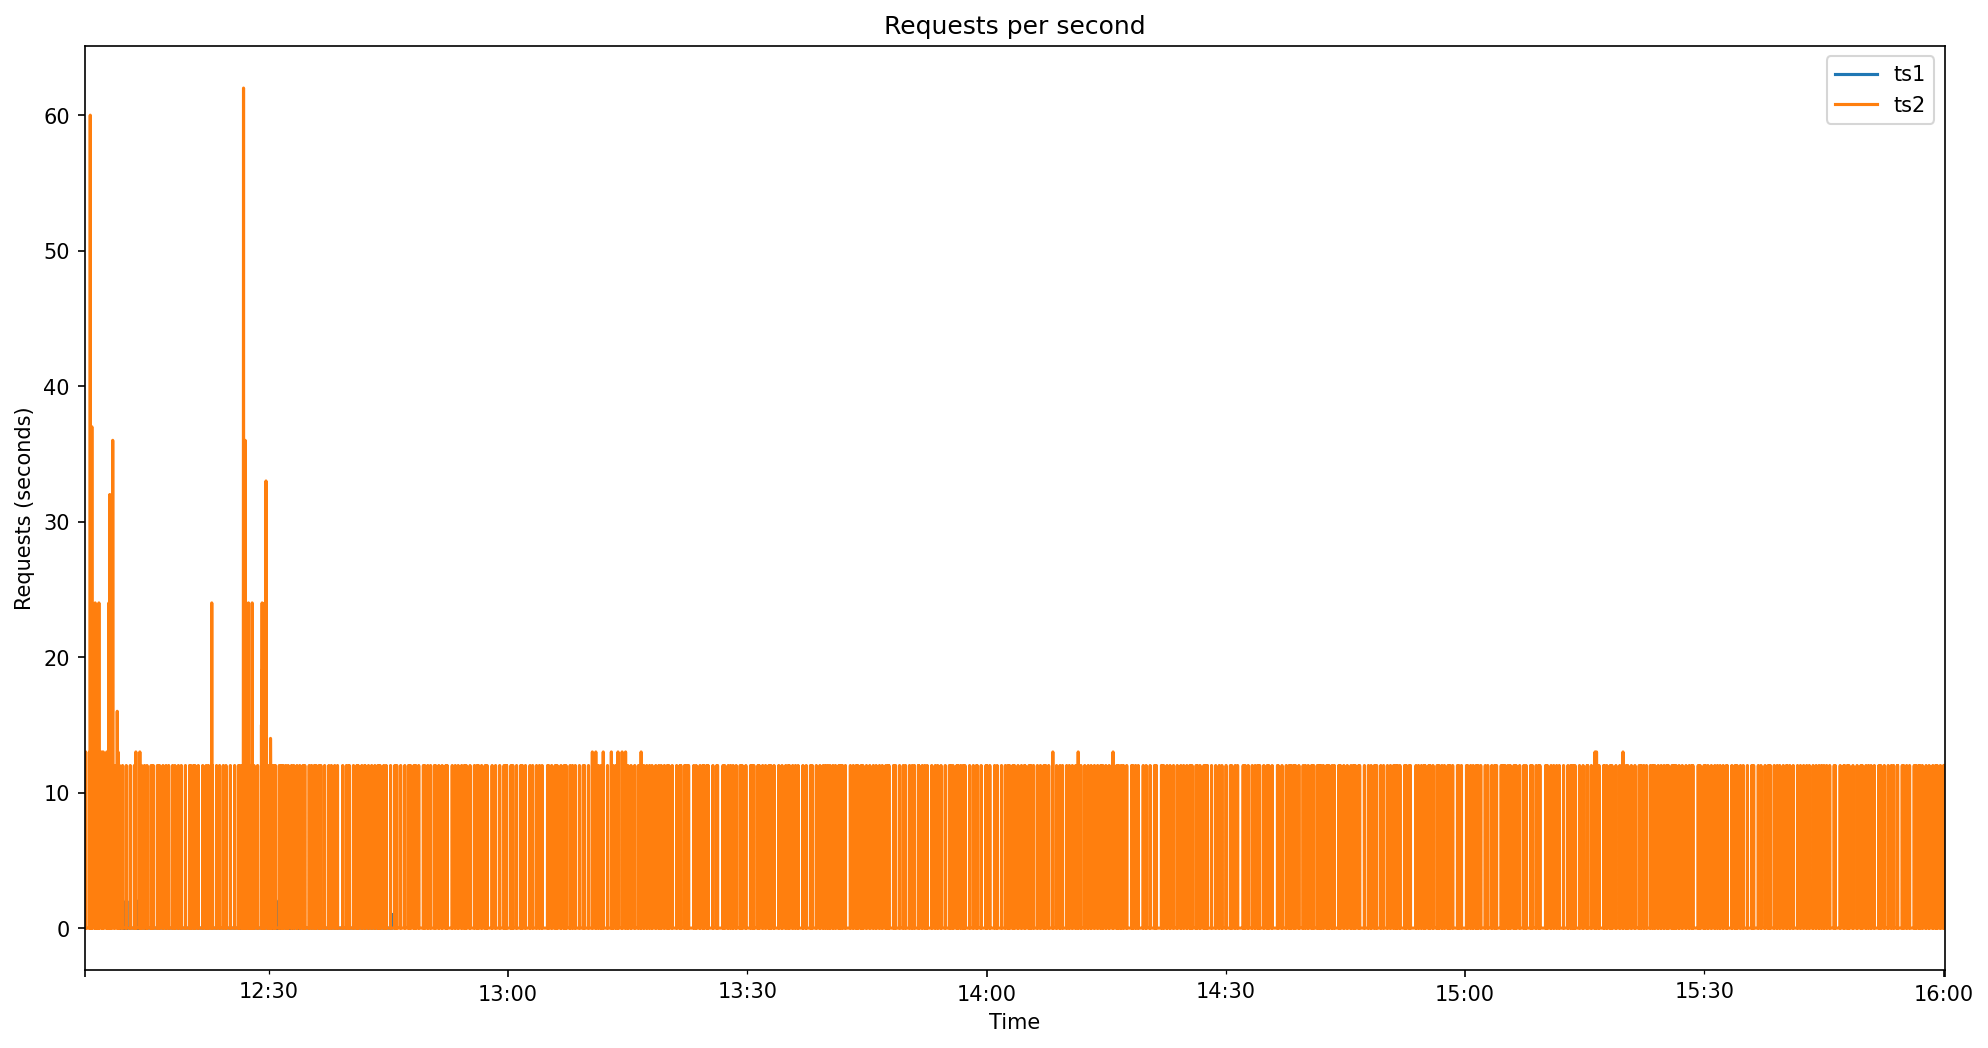

In [106]:
def plot_ts(ts1, ts2):
    # to set the plot size
    plt.figure(figsize=(16, 8), dpi=150)

    # normalize_ts(ts1['count']).plot(label='ts1')
    # normalize_ts(ts2['count']).plot(label='ts2')
    ts1['count'].plot(label='ts1')
    ts2['count'].plot(label='ts2')

    plt.title('Requests per second')

    # adding Label to the x-axis
    plt.xlabel('Time')
    plt.ylabel('Requests (seconds)')

    # adding legend to the curve
    plt.legend()
plot_ts(client_chat_logs['/tordata/config/group_0_user_0'], flows_ts_ip_total['102.0.0.10'])

In [107]:
# from scipy.cluster.hierarchy import dendrogram, linkage
# from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import squareform


# def cluster(samples, max_clust, display=False, multi_to_single=lambda x: x):
#     dist_mat = calc_dist_matrix(samples,
#                                 my_dist,
#                                 multi_to_single=multi_to_single)

#     # Perform hierarchical clustering using the computed distances
#     Z = linkage(dist_mat, method='single')

#     # Plot a dendrogram to visualize the clustering
#     if display:
#         dendrogram(Z)

#     # Extract the cluster assignments using the threshold
#     labels = fcluster(Z, max_clust, criterion='maxclust')
# #     print(labels)

#     return labels


def evaluate(src_df_dict, dst_df_dict, features, display=False):
    src_data = {key: df.loc[:, features] for key, df in src_df_dict.items()}
    for ip in src_data:
        src_data[ip] = src_data[ip][list(features)]
    num_correct = 0
    for user in dst_df_dict:
        best = None
        best_ip = None
        best_lag = None
        for ip in src_data:
            # print(user + "\t" + ip)
            score, lag = compare_ts_reshape(src_data[ip], dst_df_dict[user])
            if best == None or score < best:
                best = score
                best_ip = ip
                best_lag = lag
        times_talked = len(dst_df_dict[user].loc[~(dst_df_dict[user]==0).all(axis=1)])
        print(str(user) + 
              "\tfound: " + str(best_ip) + 
              "\t" + str(ip_to_user(best_ip)) + 
              "\t" + str(best) + 
              "\t" + str(best_lag) +
              "\t" + str(times_talked)
              , end='')
        
        if user == ip_to_user(best_ip):
            num_correct += 1
            print("\tcorrect", end='')
        print("")
    return float(num_correct)/len(dst_df_dict)

# Find best features
import itertools
from tqdm import tqdm
import multiprocessing as mp
from concurrent.futures import ProcessPoolExecutor
import os


def findsubsets(s, n):
    return list(itertools.combinations(s, n))


def evaluate_subset(src_df, dst_df, subset):
    score = evaluate(src_df, dst_df, subset)
    return score, subset


def iterate_features(src_df, dst_df, n, filename):
    features = src_df[next(iter(src_df))].columns
    subsets = findsubsets(features, n)
    results = []
    num_cpus = os.cpu_count()
    print("Using " + str(num_cpus) + " cpus for " + str(len(subsets)) + " subsets")
    with mp.Pool(processes=num_cpus) as pool:
        results = []
        for subset in subsets:
            results.append(pool.apply_async(evaluate_subset, args=(src_df, dst_df, subset)))
        with open(filename, 'a') as f:
            for result in tqdm(results, total=len(subsets)):
                score, subset = result.get()
                f.write(str(score) + "\t" + str(subset) + "\n")


flows_ts_ip_total_str_int = {}
for ip in flows_ts_ip_total:
    flows_ts_ip_total_str_int[ip] = cast_columns(flows_ts_ip_total[ip])
    
chat_log = {}
for user in client_chat_logs:
    chat_log[user] = cast_columns(client_chat_logs[user])

src_df = flows_ts_ip_total_str_int
dst_df = chat_log

dst_df_count = {}
for user in dst_df:
    dst_df_count[user] = dst_df[user][['count']]
    
single_user = '/tordata/config/group_0_user_0'
single_ip = '102.0.0.10'
dst_single = {single_user: dst_df_count[single_user]}
src_single = {single_ip: flows_ts_ip_total[single_ip]}
# plot_ts(client_chat_logs['/tordata/config/group_0_user_0'], flows_ts_ip_total['102.0.0.10'])

#purity = evaluate(src_single, dst_single, ['count'], display=True)
purity = evaluate(src_df, dst_df_count, ['count'], display=True)
print("Accuracy: " + str(purity*100) + "%")

TDA
TDA
TDA
TDA
TDA
TDA
TDA
TDA
TDA
TDA
TDA
TDA
TDA
TDA
TDA
TDA
TDA
TDA
TDA
TDA
TDA
TDA
TDA
TDA
TDA
TDA
TDA
TDA
TDA
TDA
TDA
TDA
TDA
TDA
TDA
TDA
TDA
TDA
TDA
TDA
TDA
TDA
TDA
TDA
TDA
TDA
TDA
TDA
TDA
TDA
TDA
TDA
TDA
TDA
TDA
TDA
TDA
TDA
TDA
TDA
TDA


KeyboardInterrupt: 

In [ ]:
for n in range(2,3):
    best_features = iterate_features(src_df, dst_df, n,
                                     "chatlog_dtw_dns_all_" + str(n) +
                                     "_" + str(datetime.now()) + ".output")

In [ ]:
ts1 = flows_ts_ip_total['102.0.0.81'][['count']]
ts2 = client_chat_logs['/tordata/config/group_19_user_2'][['count']]
cross_cor(ts1, ts2, debug=True)

In [ ]:
for ip in flows_ts_ip_total:
    score = compare_ts_reshape(client_chat_logs['/tordata/config/group_19_user_2'][['count']], flows_ts_ip_total[ip][['count']])
    print(ip + "\t" + str(score))
plot_ts(client_chat_logs['/tordata/config/group_15_user_3'], flows_ts_ip_total['102.0.0.68'])
print(len(client_chat_logs['/tordata/config/group_15_user_3'][client_chat_logs['/tordata/config/group_15_user_3']['count']> 0]))

In [ ]:
plot_ts(client_chat_logs['/tordata/config/group_0_user_2'], flows_ts_ip_total['102.0.0.99'])

In [ ]:
client_chat_logs['/tordata/config/group_0_user_2']